Best Hyperparameters - max_depth: 14, min_samples_leaf: 4
Train Error: 0.3237710647534369
Test Error: 0.8548593498334345


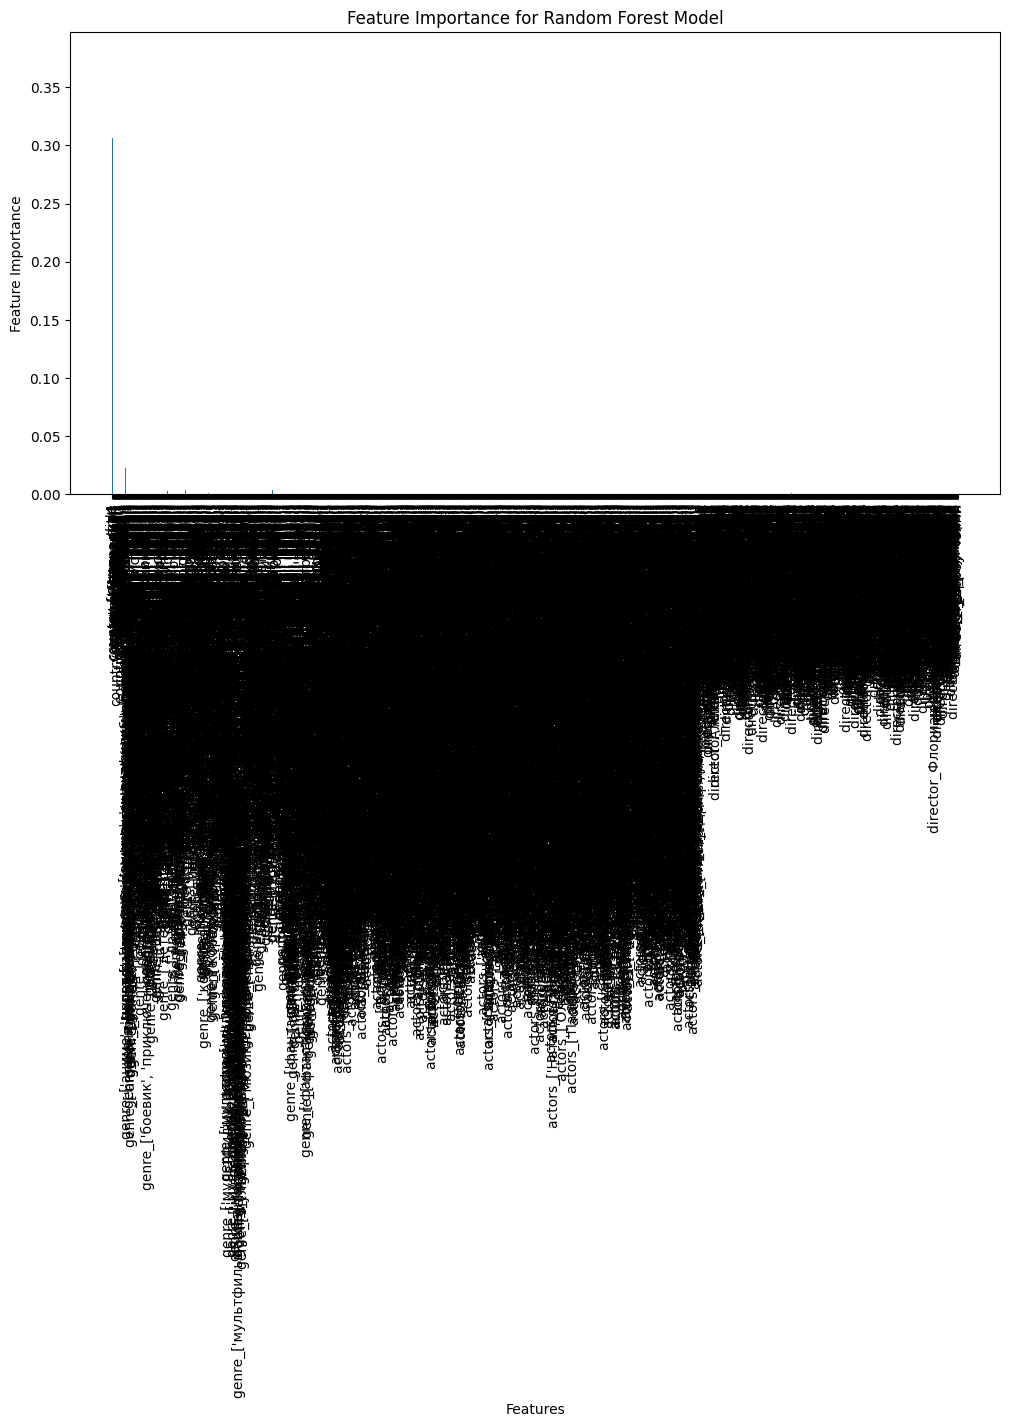

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Загрузка данных
data = pd.read_csv('datasets/data.csv')

# Заполнение пропущенных значений нулями
data = data.fillna(0)

# Удаление столбца 'description'
data = data.drop(['description'], axis=1)

# Выделение признаков и целевой переменной
X = data[['title', 'country', 'genre', 'actors', 'director', 'time']]
y = data['score']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Объединение тренировочных и тестовых данных
X_combined = pd.concat([X_train, X_test])

# Приведение всех значений столбца 'title' к строковому типу
X_combined['title'] = X_combined['title'].astype(str)

# Создание объекта LabelEncoder и преобразование категориальной переменной 'title'
label_encoder = LabelEncoder()
X_combined['title'] = label_encoder.fit_transform(X_combined['title'])

# Разделение данных на тренировочный и тестовый наборы после преобразования
X_train = X_combined[:len(X_train)]
X_test = X_combined[len(X_train):]

# Примените метод One-Hot Encoding к категориальным признакам
X_combined_encoded = pd.get_dummies(X_combined, columns=['country', 'genre', 'actors', 'director'])

# Теперь у вас есть числовое представление категориальных признаков
# Разделите данные на тренировочный и тестовый наборы
X_train_encoded = X_combined_encoded[:len(X_train)]
X_test_encoded = X_combined_encoded[len(X_train):]

# Создание и инициализация модели случайного леса с настройкой гиперпараметров и регуляризацией
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)

# Оценка модели с использованием перекрестной проверки (cross-validation) для подбора гиперпараметров
# Уменьшили количество комбинаций для ускорения выполнения
max_depth_range = range(5, 15)
min_samples_leaf_range = range(1, 6)
cv_scores = []

for max_depth in max_depth_range:
    for min_samples_leaf in min_samples_leaf_range:
        rf_model.set_params(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        scores = cross_val_score(rf_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_squared_error')
        cv_scores.append((max_depth, min_samples_leaf, np.mean(scores)))

best_params = min(cv_scores, key=lambda x: x[2])
print(f'Best Hyperparameters - max_depth: {best_params[0]}, min_samples_leaf: {best_params[1]}')

# Обучение модели с оптимальными гиперпараметрами
rf_model.set_params(max_depth=best_params[0], min_samples_leaf=best_params[1])
rf_model.fit(X_train_encoded, y_train)

# Предсказание на тренировочных и тестовых данных
y_train_pred = rf_model.predict(X_train_encoded)
y_test_pred = rf_model.predict(X_test_encoded)

# Вычисление среднеквадратичной ошибки
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print(f'Train Error: {train_error}')
print(f'Test Error: {test_error}')

# Отображение графика важности признаков
feature_importance = rf_model.feature_importances_
features = X_train_encoded.columns

plt.figure(figsize=(12, 6))
plt.bar(features, feature_importance)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Random Forest Model')
plt.xticks(rotation=90)  # Поворачиваем названия признаков для лучшей читаемости
plt.show()
